# Previsão de falhas

Galpões completos de frete Full contam com uma frota de aparelhos que transmitem telemetria adicionada diariamente em vários atributos.
As técnicas de manutenção preditiva são projetadas para ajudar a determinar a condição do equipamento de manutenção em serviço para prever quando a manutenção deve ser realizada. Essa abordagem promete economia de custos em relação à manutenção preventiva de rotina ou baseada no tempo porque as tarefas são executadas apenas quando necessárias.


Você tem a tarefa de gerar um notebook Jupyter com um modelo preditivo para prever a probabilidade de falha do dispositivo, a fim de diminuir os custos do processo. Como uma referência, uma falha de um dispositivo tem um custo de 1 enquanto o custo de uma manutenção é 0,5.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
from scipy.stats import zscore

In [3]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
dataset = pd.read_csv("datasets/full_devices.csv", encoding='ISO-8859-1',  parse_dates=['date'], infer_datetime_format=True)

In [5]:
dataset[:2]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


In [6]:
dataset.shape[0], dataset.shape[1]

(124494, 12)

In [7]:
len(dataset['device'].unique())

1169

In [8]:
dataset[dataset['failure'] == 1]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3
8823,2015-01-09,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,8,0
11957,2015-01-13,W1F13SRV,1,188251248,2040,0,0,6,39345,32,32,1
12668,2015-01-14,W1F1230J,1,220461296,0,0,0,14,325125,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
109927,2015-08-04,W1F1CB5E,1,16043296,88,0,0,9,30,0,0,0
114251,2015-08-18,Z1F0MRPJ,1,65654088,0,0,0,9,298592,0,0,11
122118,2015-10-05,S1F0JGJV,1,13739704,0,0,18,8,343760,0,0,0
122808,2015-10-09,Z1F14BGY,1,85259320,0,0,164,8,262932,0,0,0


### Análise das variáveis

#### Verificar a proporção da variável target no dataset

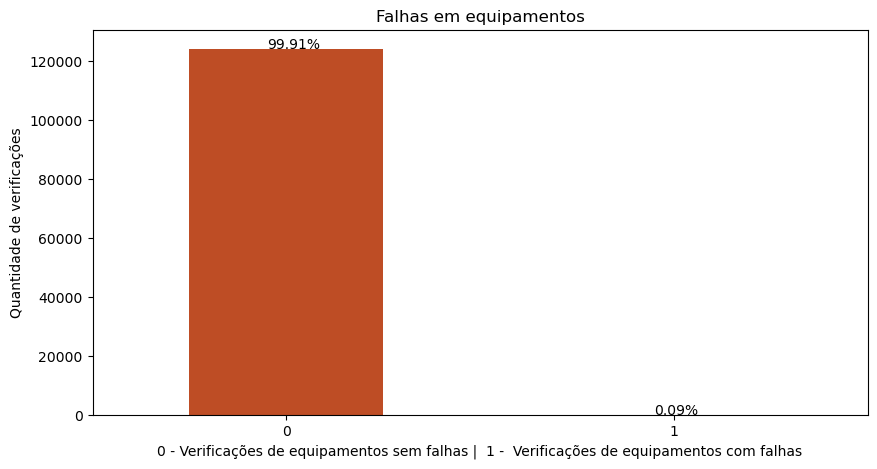

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

dataset['failure'].value_counts().plot(kind='bar',
                                 color=['#be4d25','#49be25'],
                                 figsize=(10,5),
                                 rot = 0,
                                 title="Falhas em equipamentos");

plt.xlabel("0 - Verificações de equipamentos sem falhas |  1 -  Verificações de equipamentos com falhas");
plt.ylabel("Quantidade de verificações");
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * p.get_height() / dataset.shape[0]),
                (p.get_x() + 0.20, p.get_height() + 30))
plt.show()

Observa-se pelos gráficos que temos uma base desbalanceada, em que 99,91% das verificações realizadas os equipamentos não estavam com falhas.  Para criar um modelo preditivo, precisamos selecionar as variáveis disponíveis observando sua distribuição e qualidade dos dados e então escolher as melhores para serem utilizadas.

In [10]:
ts = dataset[dataset['failure'] == 1].copy()
ts = ts.groupby(['date']).agg({
     "device": "count"
}).reset_index()
ts.set_index('date')

fig = px.line(ts, x='date', y='device', title='Distribuição das falhas de equipamento ao longo do tempo',
              labels={
            'date': "Data da falha",
            'device': "Quantidade de falhas"
            })
fig.update_layout(yaxis_title=None )
fig.update_traces(line_color='red')
fig.show()

In [11]:
ts['device'].median()

1.0

Ao analisar a distribuição das falhas de equipamentos ao longo dos dias nesse dataset, percebe-se que os eventos de falha de equipamentos são mais raros, com algumas exceções como o dia 19/01/2015 em que ocorreram 8 falhas. Na maioria dos dias em que ocorreram falhas, ocorreram no máximo 1 falha por dia, em alguns dias mais esporádicos ocorreram duas falhas.

#### Verificação de dados nulos na base

##### Total de registros nulos por variável:

In [11]:
dataset.isna().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

##### Distribuição dos dados

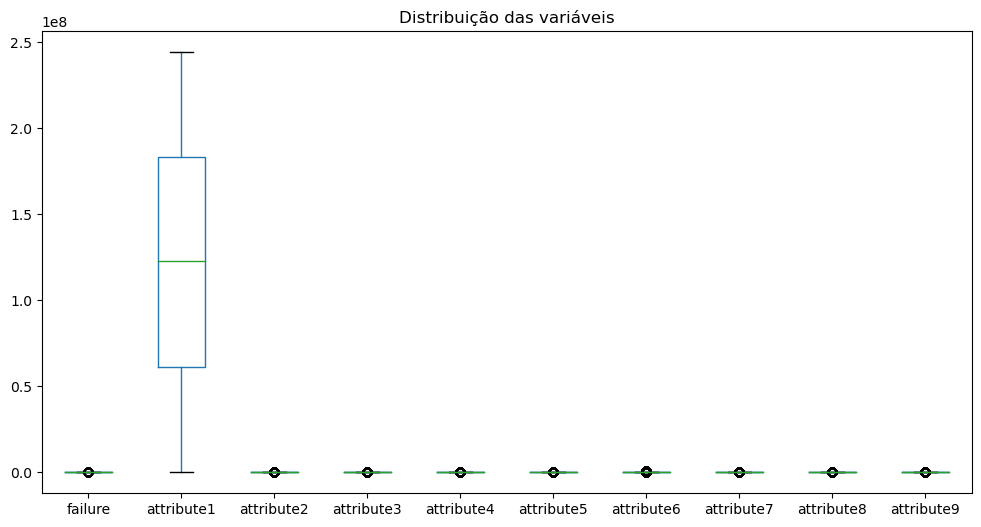

In [12]:
plt.figure(figsize=(12,6))
ax = plt.axes()

dataset.boxplot();
ax.set_title('Distribuição das variáveis')
ax.grid(False)
plt.show();

Com esse gráfico, podemos perceber que há algumas variáveis com outliers na base. Ao tentar removê-los os dados de falhas eram removidos do dataset devido a pouca quantidade de falhas na base e devido a ser justamente a condição de anomalia. Irei mantê-los e testar se é possível criar um bom modelo 

## Normalização e preparação das variáveis 

Iremos testar além da redução de outliers, uma técnica de padronização dos dados. A padronização envolve o reescalonamento dos recursos de modo que eles tenham as propriedades de uma distribuição normal padrão com uma média de zero e um desvio padrão de um. Isso também ajuda a diminuir a influência de valores muito altos nos pesos dos algoritmos.


In [12]:
def normalizeColumns(dataset, columns):
    for col in columns:
        dataset[col] = MinMaxScaler().fit_transform(dataset[col].values.reshape(-1, 1))
    return dataset

### Normalização da base

In [13]:
colunas = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

In [14]:
dataset_norm = dataset.copy()
dataset_norm = normalizeColumns(dataset_norm, colunas)

In [15]:
dataset_norm

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,0.883224,0.000862,0.000000,0.031212,0.051546,0.591204,0.000000,0.000000,0.000374
1,2015-01-01,S1F0166B,0,0.251374,0.000000,0.000120,0.000000,0.051546,0.585017,0.000000,0.000000,0.000000
2,2015-01-01,S1F01E6Y,0,0.709821,0.000000,0.000000,0.000000,0.113402,0.344461,0.000000,0.000000,0.000000
3,2015-01-01,S1F01JE0,0,0.326427,0.000000,0.000000,0.000000,0.051546,0.595191,0.000000,0.000000,0.000000
4,2015-01-01,S1F01R2B,0,0.556935,0.000000,0.000000,0.000000,0.144330,0.454420,0.000000,0.000000,0.000160
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,0.074999,0.000000,0.000000,0.000000,0.092784,0.513234,0.009615,0.009615,0.000000
124490,2015-11-02,Z1F0Q8RT,0,0.706793,0.001478,0.004292,0.002401,0.103093,0.482888,0.000000,0.000000,0.000695
124491,2015-11-02,Z1F0QK05,0,0.077943,0.074375,0.000000,0.000000,0.103093,0.508453,0.000000,0.000000,0.000000
124492,2015-11-02,Z1F0QL3N,0,0.929602,0.000000,0.000000,0.000000,0.113402,0.520889,0.000000,0.000000,0.000000


## Primeira tentativa de selecionar modelos

Para avaliar as bases, iremos utilizar as seguintes métricas:

- **Acurácia:** A acurácia (accuracy ou ACC) é considerada uma das métricas mais simples e importantes. Ela avalia simplesmente o percentual de acertos, ou seja, ela pode ser obtida pela razão entre a quantidade de acertos e o total de entradas.

- **AUC ou Curva ROC**: A curva Receiver Operator Characteristic (ROC) é uma métrica de avaliação para problemas de classificação binária. É uma curva de probabilidade que plota o TPR (True Positive Rate ou Taxa de Verdadeiros Positivos) contra o FPR (False Positive Rate ou Taxa de Falsos Positivos) em vários valores limite e essencialmente separa o 'sinal' do 'ruído'. A área sob a curva (AUC) é a medida da capacidade de um classificador para distinguir entre classes e é usada como um resumo da curva ROC.

    Quanto maior a AUC, melhor o desempenho do modelo em distinguir entre as classes positivas e negativas.

- **F1:** As métricas de Precisão (é uma métrica que avalia a quantidade de verdadeiros positivos sobre a soma de todos os valores positivos) e Recall (É uma métrica calculada como a razão entre o número de amostras Positivas corretamente classificadas como Positivas e o número total de amostras Positivas.O recall mede a capacidade do modelo de detectar amostras positivas. Quanto maior, mais amostras positivas detectadas) são os dois blocos de construção da pontuação da F1. O objetivo da pontuação F1 é combinar as métricas de precisão e recall em uma única métrica. Ao mesmo tempo, a pontuação F1 foi projetada para funcionar bem em dados desequilibrados.


- Bases a serem utilizadas:

In [17]:
# Base sem normalização e com outliers
dataset.head(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


In [18]:
# Base normalizada e com outliers
dataset_norm.head(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,0.883224,0.000862,0.00000,0.031212,0.051546,0.591204,0.0,0.0,0.000374
1,2015-01-01,S1F0166B,0,0.251374,0.000000,0.00012,0.000000,0.051546,0.585017,0.0,0.0,0.000000


In [16]:
def splitDataset(df):
  X = df[df.columns.difference(['date','device',"failure"])]
  y = df['failure']
  return X,y

In [17]:
def testarModelos(X,y):
     # divide em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=999)


    modelos = []
    modelos.append(('LR', LogisticRegression(max_iter=5000)))
    modelos.append(('LDA', LinearDiscriminantAnalysis()))
    modelos.append(('KNN', KNeighborsClassifier()))
    modelos.append(('NB', GaussianNB()))
    modelos.append(('SVM', SVC()))
    modelos.append(('CART', DecisionTreeClassifier()))
    modelos.append(('AB', AdaBoostClassifier()))  
    modelos.append(('GBM', GradientBoostingClassifier()))
    modelos.append(('RF', RandomForestClassifier()))
    modelos.append(('ET', ExtraTreesClassifier()))
    modelos.append(('MLPC', MLPClassifier()))
    modelos.append(('XGB', XGBClassifier()))

    resultados = []
    nomes = []

    # Percorrendo cada um dos modelos
    for nome, modelo in modelos:
        print(f"Executando o treinamento no modelo: {nome}")
        kfold = model_selection.KFold(n_splits=10, random_state = 7, shuffle=True)

        dados_modelo = dict()

        dados_modelo["modelo"] = nome 
        dados_modelo["acuracia"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'accuracy').mean()
        dados_modelo["curva_roc"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'roc_auc').mean()
        dados_modelo["f1_score"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'f1').mean()
        dados_modelo["precisao"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'precision' ).mean()

        resultados.append(dados_modelo)

    return pd.DataFrame(resultados)

In [18]:
def testarModelosReduzido(X,y):
     # divide em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=999)


    modelos = []
    modelos.append(('LR', LogisticRegression(max_iter=5000)))
    modelos.append(('LDA', LinearDiscriminantAnalysis()))
    modelos.append(('KNN', KNeighborsClassifier()))
    modelos.append(('CART', DecisionTreeClassifier()))
    modelos.append(('AB', AdaBoostClassifier()))  
    modelos.append(('GBM', GradientBoostingClassifier()))
    modelos.append(('RF', RandomForestClassifier()))
    modelos.append(('XGB', XGBClassifier()))

    resultados = []
    nomes = []

    # Percorrendo cada um dos modelos
    for nome, modelo in modelos:
        print(f"Executando o treinamento no modelo: {nome}")
        kfold = model_selection.KFold(n_splits=10, random_state = 7, shuffle=True)

        dados_modelo = dict()

        dados_modelo["modelo"] = nome 
        dados_modelo["acuracia"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'accuracy').mean()
        dados_modelo["curva_roc"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'roc_auc').mean()
        dados_modelo["f1_score"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'f1').mean()
        dados_modelo["precisao"] = model_selection.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'precision' ).mean()

        resultados.append(dados_modelo)

    return pd.DataFrame(resultados)

### Teste com a Base1: Base sem normalização e com outliers

In [22]:
X, y = splitDataset(dataset)

In [23]:
teste_base1 = testarModelos(X, y)

Executando o treinamento no modelo: LR
Executando o treinamento no modelo: LDA
Executando o treinamento no modelo: KNN
Executando o treinamento no modelo: NB
Executando o treinamento no modelo: SVM
Executando o treinamento no modelo: CART
Executando o treinamento no modelo: AB
Executando o treinamento no modelo: GBM
Executando o treinamento no modelo: RF
Executando o treinamento no modelo: ET
Executando o treinamento no modelo: MLPC
Executando o treinamento no modelo: XGB


In [24]:
teste_base1.sort_values(by=['curva_roc','f1_score','precisao'], ascending=False)[:3]

,modelo,acuracia,curva_roc,f1_score,precisao
7,GBM,0.998933,0.856668,0.092901,0.151667
11,XGB,0.999048,0.843339,0.015385,0.100000
1,LDA,0.995479,0.817272,0.083308,0.052538


### Teste com a Base2: Base com normalização e com outliers

In [25]:
X, y = splitDataset(dataset_norm)

In [26]:
teste_base2 = testarModelos(X, y)

Executando o treinamento no modelo: LR
Executando o treinamento no modelo: LDA
Executando o treinamento no modelo: KNN
Executando o treinamento no modelo: NB
Executando o treinamento no modelo: SVM
Executando o treinamento no modelo: CART
Executando o treinamento no modelo: AB
Executando o treinamento no modelo: GBM
Executando o treinamento no modelo: RF
Executando o treinamento no modelo: ET
Executando o treinamento no modelo: MLPC
Executando o treinamento no modelo: XGB


In [27]:
teste_base2.sort_values(by=['curva_roc','f1_score','precisao'], ascending=False)[:3]

,modelo,acuracia,curva_roc,f1_score,precisao
7,GBM,0.998967,0.856615,0.077516,0.135000
11,XGB,0.999048,0.843340,0.015385,0.100000
1,LDA,0.995479,0.817272,0.083308,0.052538


Observa-se que as bases tiveram desempenhos bem parecidos ao serem comparadas. Serão feitos também novos testes abaixo adicionando oversampling e undersampling nas bases para tentar melhorar a precisão e o f1 score

## Segunda tentativa de selecionar modelos - Usando técnicas de balanceamento das bases

### Undersampling

In [28]:
def applyUndersampler(df):
    X = df[df.columns.difference(['date','device',"failure"])]
    y = df['failure']

    # Random Undersampler
    rus = RandomUnderSampler(random_state = 32)
    X_rus_res, y_rus_res = rus.fit_resample(X, y)

    return X_rus_res, y_rus_res

#### Teste com a Base1: Base sem normalização

In [29]:
X,y = applyUndersampler(dataset)
teste_base1 = testarModelos(X, y)

Executando o treinamento no modelo: LR
Executando o treinamento no modelo: LDA
Executando o treinamento no modelo: KNN
Executando o treinamento no modelo: NB
Executando o treinamento no modelo: SVM
Executando o treinamento no modelo: CART
Executando o treinamento no modelo: AB
Executando o treinamento no modelo: GBM
Executando o treinamento no modelo: RF
Executando o treinamento no modelo: ET
Executando o treinamento no modelo: MLPC
Executando o treinamento no modelo: XGB


In [30]:
teste_base1.sort_values(by=['curva_roc','f1_score','precisao'], ascending=False)[:3]

,modelo,acuracia,curva_roc,f1_score,precisao
8,RF,0.803810,0.904201,0.784622,0.780437
11,XGB,0.797619,0.903636,0.780326,0.784524
9,ET,0.804286,0.881351,0.741858,0.812143


#### Teste com a Base2: Base com normalização

In [31]:
X,y = applyUndersampler(dataset_norm)
teste_base2= testarModelos(X, y)

Executando o treinamento no modelo: LR
Executando o treinamento no modelo: LDA
Executando o treinamento no modelo: KNN
Executando o treinamento no modelo: NB
Executando o treinamento no modelo: SVM
Executando o treinamento no modelo: CART
Executando o treinamento no modelo: AB
Executando o treinamento no modelo: GBM
Executando o treinamento no modelo: RF
Executando o treinamento no modelo: ET
Executando o treinamento no modelo: MLPC
Executando o treinamento no modelo: XGB


In [32]:
teste_base2.sort_values(by=['curva_roc','f1_score','precisao'], ascending=False)[:3]

,modelo,acuracia,curva_roc,f1_score,precisao
11,XGB,0.797619,0.903636,0.780326,0.784524
8,RF,0.803810,0.891483,0.793903,0.804246
9,ET,0.804762,0.887241,0.780862,0.806746


### Oversampling

In [19]:
def applyOversampler(df):
    X = df[df.columns.difference(['date','device',"failure"])]
    y = df['failure']
   
    ros = RandomOverSampler(random_state = 32)
    X_ros_res, y_ros_res = ros.fit_resample(X, y)

    return X_ros_res, y_ros_res

#### Teste com a Base1: Base sem normalização 

In [34]:
X,y = applyOversampler(dataset)
teste_base1 = testarModelosReduzido(X, y)

Executando o treinamento no modelo: LR
Executando o treinamento no modelo: LDA
Executando o treinamento no modelo: KNN
Executando o treinamento no modelo: CART
Executando o treinamento no modelo: AB
Executando o treinamento no modelo: GBM
Executando o treinamento no modelo: RF
Executando o treinamento no modelo: XGB


In [35]:
teste_base1.sort_values(by=['curva_roc','f1_score','precisao'], ascending=False)[:3]

,modelo,acuracia,curva_roc,f1_score,precisao
6,RF,0.999782,0.999994,0.999776,0.999552
7,XGB,0.999472,0.999963,0.999472,0.998944
3,CART,0.999449,0.999391,0.999432,0.998819


#### Teste com a Base2: Base com normalização

In [20]:
X,y = applyOversampler(dataset_norm)
teste_base2= testarModelosReduzido(X, y)

Executando o treinamento no modelo: LR
Executando o treinamento no modelo: LDA
Executando o treinamento no modelo: KNN
Executando o treinamento no modelo: CART
Executando o treinamento no modelo: AB
Executando o treinamento no modelo: GBM
Executando o treinamento no modelo: RF
Executando o treinamento no modelo: XGB


In [21]:
teste_base2.sort_values(by=['curva_roc','f1_score','precisao'], ascending=False)[:3]

,modelo,acuracia,curva_roc,f1_score,precisao
6,RF,0.999788,0.999994,0.999770,0.999529
7,XGB,0.999472,0.999963,0.999472,0.998944
2,KNN,0.998800,0.999627,0.998802,0.997607


## Resultados encontrados

Após todos os testes realizados, a melhor combinação de técnicas e processamentos é a seguinte: A base com normalização dos dados, sem outliers. Essa combinação em geral teve uma performance melhor em relação aos outros testes. Será feita a comparação dos modelos XGBoost e o RandomForestClassifier que tiveram as melhores performances nos testes.

## Teste dos modelos

In [22]:
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold

In [23]:
classes=["Sem falhas","Com falhas"]

In [24]:
def splitTrainTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=999)
    return X_train, X_test, y_train, y_test

In [25]:
def splitVars(df):
    X = df[df.columns.difference(['date','device',"failure"])]
    y = df['failure']
    return X, y

In [26]:
def applyUndersamplerVars(X, y):
    rus = RandomUnderSampler(random_state = 32)
    X_rus, y_rus = rus.fit_resample(X, y)

    return X_rus, y_rus

In [27]:
def applyOversamplerVars(X, y):
    ros = RandomOverSampler(random_state = 32)
    X_ros, y_ros = ros.fit_resample(X, y)

    return X_ros, y_ros

In [28]:
def plotarMatrizConfusao(model, classes, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    matriz = ConfusionMatrix(model, classes=classes, percent=True)
    matriz.fit(X_train, y_train)
    matriz.score(X_test, y_test)
    matriz.show()

In [29]:
def plotarCurvaROC(model, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(4,4))
    ax = plt.axes()
    viz = ROCAUC(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

In [30]:
xgb = XGBClassifier(random_state=23)
rf = RandomForestClassifier(random_state=23)

### Undersampling

#### Teste com a Base1: Base sem normalização

In [31]:
X, y = splitVars(dataset)
x_train_b1,x_test_b1,y_train_b1,y_test_b1 = splitTrainTest(X,y)
x_train_b1,y_train_b1 = applyUndersamplerVars(x_train_b1,y_train_b1)
xgb.fit(x_train_b1,y_train_b1)
rf.fit(x_train_b1,y_train_b1)

RandomForestClassifier(random_state=23)

##### Resultados com RandomForest

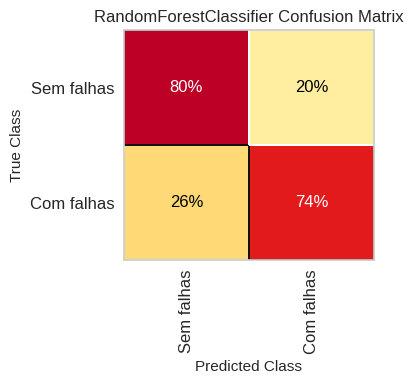

In [32]:
plotarMatrizConfusao(rf,classes,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

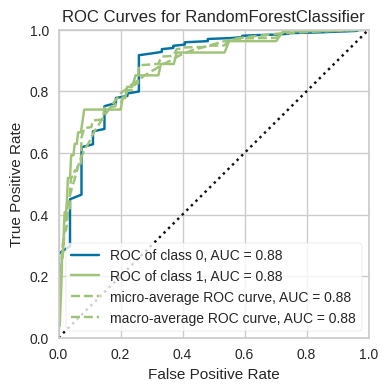

In [33]:
plotarCurvaROC(rf,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

##### Resultados com XGBClassifier

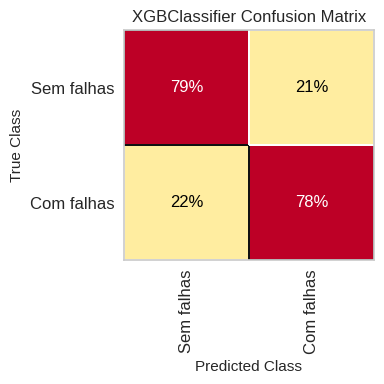

In [34]:
plotarMatrizConfusao(xgb,classes,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

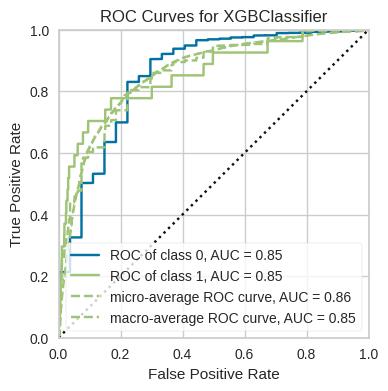

In [35]:
plotarCurvaROC(xgb,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

#### Teste com a Base2: Base com normalização

In [36]:
X, y = splitVars(dataset_norm)
x_train_b2,x_test_b2,y_train_b2,y_test_b2 = splitTrainTest(X,y)
x_train_b2,y_train_b2 = applyUndersamplerVars(x_train_b1,y_train_b1)
xgb.fit(x_train_b2,y_train_b2)
rf.fit(x_train_b2,y_train_b2)

RandomForestClassifier(random_state=23)

##### Resultados com RandomForest

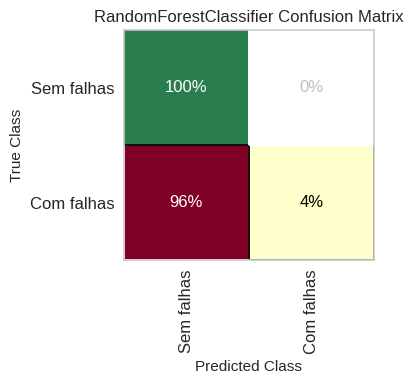

In [37]:
plotarMatrizConfusao(rf,classes,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

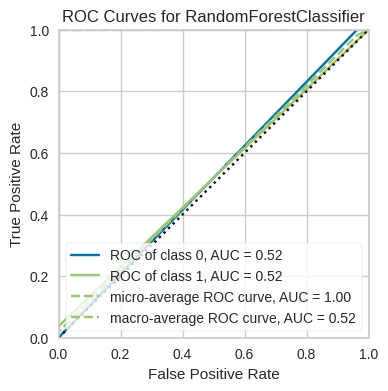

In [38]:
plotarCurvaROC(rf,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

##### Resultados com XGBClassifier

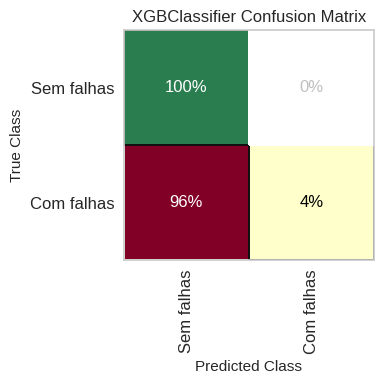

In [39]:
plotarMatrizConfusao(xgb,classes,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

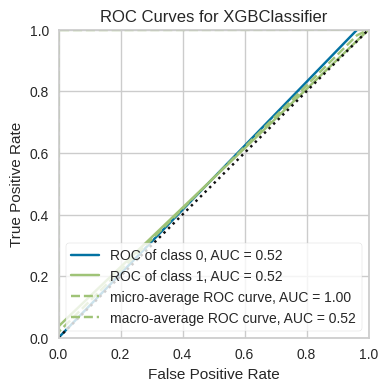

In [40]:
plotarCurvaROC(xgb,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

### Oversampling

#### Teste com a Base1: Base sem normalização

In [41]:
X, y = splitVars(dataset)
x_train_b1,x_test_b1,y_train_b1,y_test_b1 = splitTrainTest(X,y)
x_train_b1,y_train_b1 = applyOversamplerVars(x_train_b1,y_train_b1)
xgb.fit(x_train_b1,y_train_b1)
rf.fit(x_train_b1,y_train_b1)

RandomForestClassifier(random_state=23)

##### Resultados com RandomForest

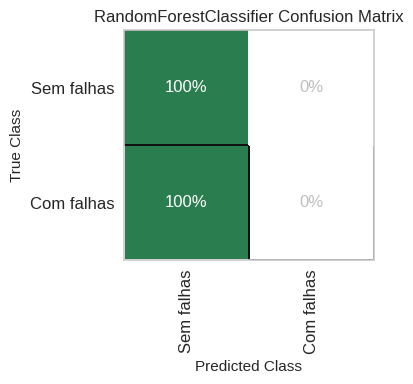

In [42]:
plotarMatrizConfusao(rf,classes,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

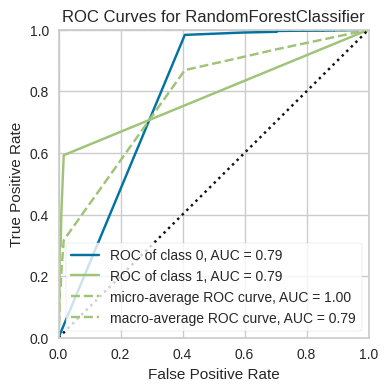

In [43]:
plotarCurvaROC(rf,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

##### Resultados com XGBClassifier

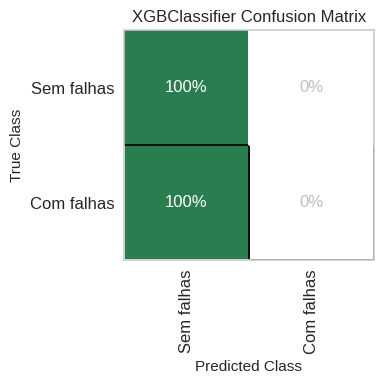

In [44]:
plotarMatrizConfusao(xgb,classes,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

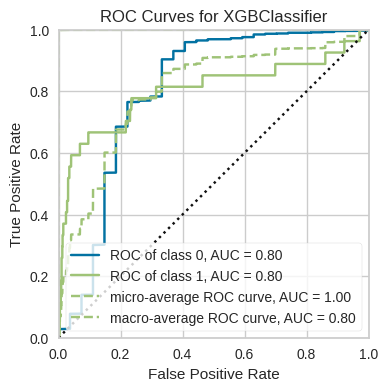

In [45]:
plotarCurvaROC(xgb,x_train_b1, x_test_b1, y_train_b1, y_test_b1)

#### Teste com a Base2: Base com normalização

##### Resultados com RandomForest

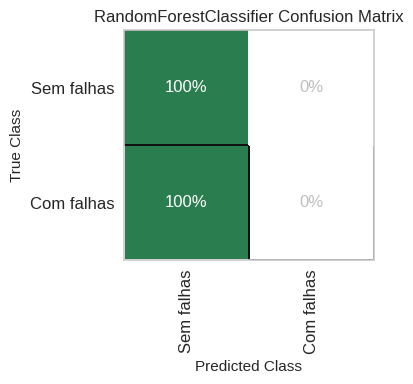

In [46]:
plotarMatrizConfusao(rf,classes,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

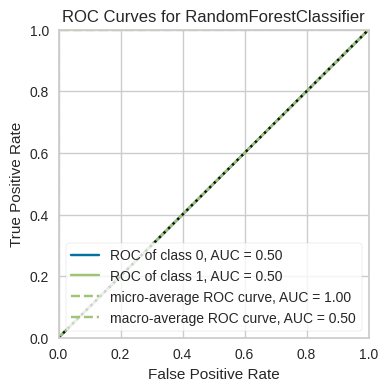

In [47]:
plotarCurvaROC(rf,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

##### Resultados com XGBClassifier

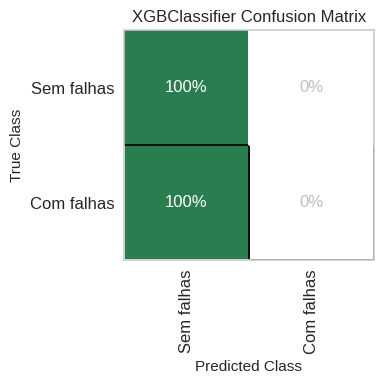

In [48]:
plotarMatrizConfusao(xgb,classes,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

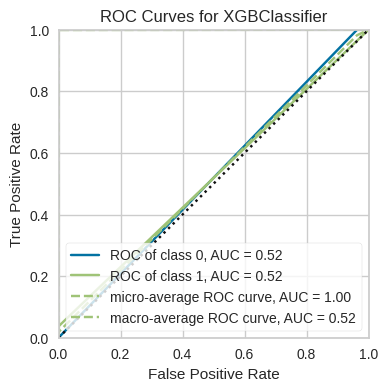

In [49]:
plotarCurvaROC(xgb,x_train_b2, x_test_b2, y_train_b2, y_test_b2)

# Resultados

De forma geral, os testes com Undersampling tiveram um melhor resultado quando comparado aos modelos e bases processadas com oversampling, devido a um problema de overfitting - Os modelos treinados com oversampling ficaram muito tendenciosos em relação a classe que possui mais dados (dias sem falhas de equipamentos ou com pouquíssimas falhas), sendo o melhor resultado o do modelo Random Forest usando uma base não normalizada